 # Manipulação de Mapas e Cruzamento de Dados
 
Este notebook documenta o processo de manipulação de mapas e a integração dos dados meteorológicos do INMET com os dados de geração de energia solar da ONS. O objetivo é cruzar essas informações em uma única base de dados, facilitando análises e previsões mais precisas sobre a geração de energia solar.

 ## Importação de Bibliotecas Necessárias

In [1]:
import os # Biblioteca para manipulação de arquivos e diretórios
import sys # Biblioteca para manipulação de caminhos do sistema
import pandas as pd # Biblioteca para manipulação de dataframes
import geopandas as gpd # Biblioteca para manipulação de geodataframes
import matplotlib.pyplot as plt # Biblioteca para plotar gráficos

# Ajuste do sys.path para incluir o diretório src
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Importar funções específicas do projeto
from data_manipulation_and_merging import *
from database import create_connection, query_data

 ## Conexão com o Banco de Dados

 Conectamos ao banco de dados SQLite para extrair os dados necessários.

In [2]:
# Conexão com o banco de dados
current_dir = os.getcwd()  # Diretório de trabalho atual, que é dentro de 'data'
repository_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Voltar um nível para o diretório do repositório
db_file = os.path.join(repository_dir, 'data', 'processed', 'dados_solar.db')
conn = create_connection(db_file)  # Função personalizada para criar uma conexão com o banco de dados

## Manipulação de Mapas

### Leitura do Shapefile de Minas Gerais

<Axes: >

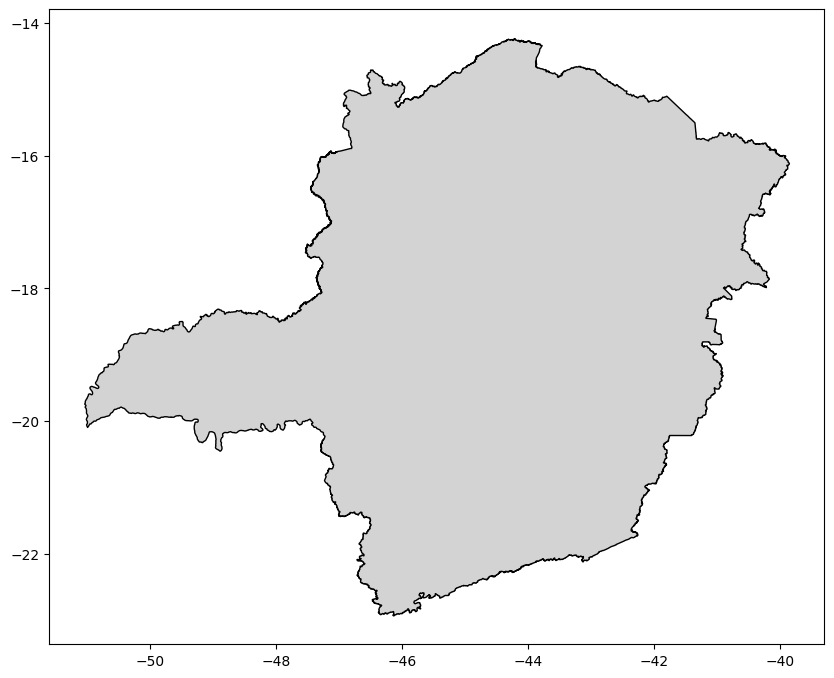

In [3]:
# Caminho do arquivo shapefile de Minas Gerais
shapefile_path = os.path.join(repository_dir, 'data', 'external', 'shapefiles', 'MG_UF_2022', 'MG_UF_2022.shp')
gdf_mg = gpd.read_file(shapefile_path)

# Plotar o mapa de Minas Gerais
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_mg.plot(ax=ax, color='lightgrey', edgecolor='black')

### Estações Meteorológicas Georreferenciadas

Transformamos as coordenadas de latitude e longitude para tipos numéricos e criamos um GeoDataFrame.

In [4]:
# Importar dados das estações meteorológicas do INMET
query_inmet = "SELECT DISTINCT estacao, latitude, longitude FROM dados_inmet"
df_inmet = query_data(conn, query_inmet)
display(df_inmet.head())

,estacao,latitude,longitude
0,BARBACENA,"-21,22888888","-43,76694443"
1,ARAXA,"-19,60555555","-46,94944444"
2,MONTES CLAROS,"-16,71666666","-43,86666666"
3,UBERLANDIA,"-18,91722221","-48,25555555"
4,ALMENARA,"-16,16666666","-40,68777777"


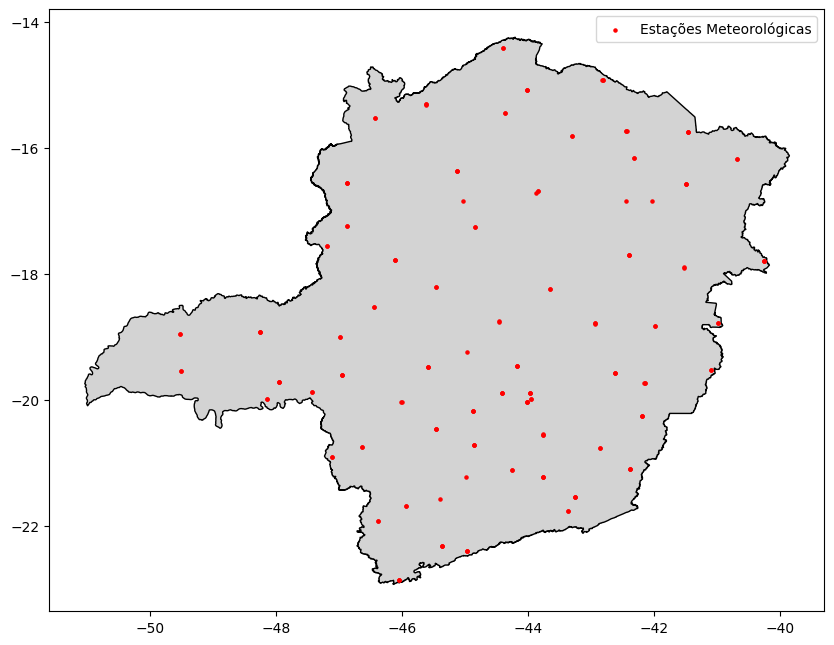

In [5]:
# Converter latitude e longitude para float
df_inmet['latitude'] = df_inmet['latitude'].str.replace(',', '.').astype(float)
df_inmet['longitude'] = df_inmet['longitude'].str.replace(',', '.').astype(float)

# Criar um GeoDataFrame a partir do DataFrame
gdf_inmet = gpd.GeoDataFrame(df_inmet, geometry=gpd.points_from_xy(df_inmet.longitude, df_inmet.latitude))

# Filtrar estações dentro dos limites de Minas Gerais
gdf_inmet_filtered = gdf_inmet[gdf_inmet.within(gdf_mg.unary_union)]

# Identificar e remover pontos fora dos limites de Minas Gerais
outliers = gdf_inmet[~gdf_inmet.within(gdf_mg.unary_union)]

# Plotar as estações meteorológicas do INMET em Minas Gerais
fig, ax = plt.subplots(figsize=(10, 10))
gdf_mg.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_inmet_filtered.plot(ax=ax, marker='o', color='red', markersize=5, label='Estações Meteorológicas')
plt.legend()
plt.show()

### Usinas Solares WebMapEPE

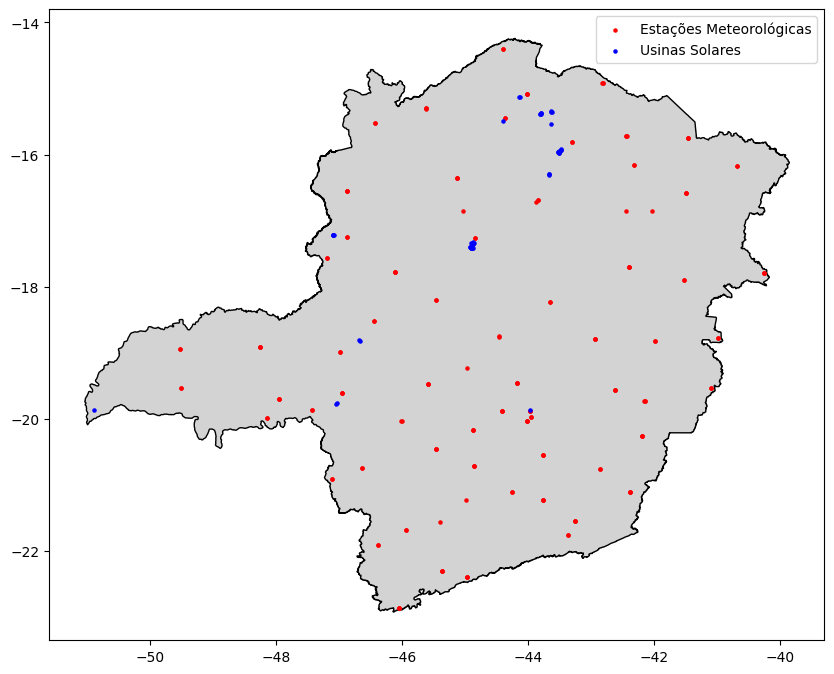

In [7]:
# Leitura do caminho do arquivo shapefile de usinas solares
usinas_solares_path = os.path.join(repository_dir, 'data', 'external', 'shapefiles', 'POWER_PLANTS', 'ph_mg.shp')
usinas_solares = gpd.read_file(usinas_solares_path)

# Plotar as usinas solares em Minas Gerais
fig, ax = plt.subplots(figsize=(10, 10))
gdf_mg.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_inmet_filtered.plot(ax=ax, marker='o', color='red', markersize=5, label='Estações Meteorológicas')
usinas_solares.plot(ax=ax, marker='o', color='blue', markersize=5, label='Usinas Solares')
plt.legend()
plt.show()

### Estação Mais Próxima das Usinas
Calculamos a estação meteorológica mais próxima de cada usina solar.

In [8]:
# Adicionar colunas de latitude e longitude
usinas_solares['latitude'] = usinas_solares.geometry.y
usinas_solares['longitude'] = usinas_solares.geometry.x
gdf_inmet_filtered['latitude'] = gdf_inmet_filtered.geometry.y
gdf_inmet_filtered['longitude'] = gdf_inmet_filtered.geometry.x

# Lista para armazenar os resultados
resultados = []

# Itera sobre todas as usinas solares
for _, usina in usinas_solares.iterrows():
    usina_coord = (usina['latitude'], usina['longitude'])
    menor_distancia = float('inf')
    estacao_mais_proxima = None
    
    # Itera sobre todas as estações meteorológicas
    for _, estacao in gdf_inmet_filtered.iterrows():
        estacao_coord = (estacao['latitude'], estacao['longitude'])
        distancia = calcular_distancia(usina_coord, estacao_coord)
        
        if distancia < menor_distancia:
            menor_distancia = distancia
            estacao_mais_proxima = estacao['estacao']
    
    resultados.append({'ceg': usina['ceg'], 'estacao': estacao_mais_proxima, 'usina': usina['nome']})

usina_estacao_relacionada = pd.DataFrame(resultados)

# Display 
display(usina_estacao_relacionada)

C:\Users\afaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ceg,estacao,usina
0,UFV.RS.SP.034161-4.02,CAMPINA VERDE,Boa Hora 1
1,UFV.RS.SP.034107-0.01,JANAUBA,Brisas Suaves
2,UFV.RS.MG.037404-0.01,MONTALVANIA,AC IV
3,UFV.RS.MG.032323-3.02,JANUARIA,FCR III Itapuranga
4,UFV.RS.MG.043223-7.01,MOCAMBINHO,Ita 01
5,UFV.RS.MG.043268-7.01,MOCAMBINHO,Ita 02
6,UFV.RS.MG.031760-8.01,BELO HORIZONTE (PAMPULHA),Central Mineirão
7,UFV.RS.MG.033193-7.01,PIRAPORA,Pirapora 10
8,UFV.RS.MG.033185-6.01,PIRAPORA,Pirapora 2
9,UFV.RS.MG.033186-4.01,PIRAPORA,Pirapora 3


In [21]:
# Obter dados meteorológicos das estações mais próximas das usinas
query_inmet = "SELECT * FROM dados_inmet WHERE estacao IN ({})".format(
    ', '.join(['"{}"'.format(estacao) for estacao in usina_estacao_relacionada['estacao']])
)

df_inmet = query_data(conn, query_inmet)

# Tratamento dos dados
df_inmet = tratamento_data(df_inmet)

# # Adicionar a coluna de CEG a partir da tabela usina_estacao_relacionada
df_inmet = df_inmet.merge(usina_estacao_relacionada, on='estacao', how='inner')

# Display
display(df_inmet.head())

c:\Users\afaze\OneDrive\Documentos\Github\SolarEnergyPred\src\data_manipulation_and_merging.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['data_completa', 'hora'], inplace=True)


,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,latitude,longitude,altitude,data_hora_completa,ceg,usina
0,ARAXA,None,"20,2",84.0,"2,8","-19,605696","-46,949617","1018,32",2019-01-01 00:00:00,UFV.RS.MG.040851-4.01,Araxá 1
1,ARAXA,None,"20,2",84.0,"2,8","-19,605696","-46,949617","1018,32",2019-01-01 00:00:00,UFV.RS.MG.040852-2.01,Araxá 2
2,ARAXA,None,"20,1",90.0,"2,4","-19,605696","-46,949617","1018,32",2019-01-01 01:00:00,UFV.RS.MG.040851-4.01,Araxá 1
3,ARAXA,None,"20,1",90.0,"2,4","-19,605696","-46,949617","1018,32",2019-01-01 01:00:00,UFV.RS.MG.040852-2.01,Araxá 2
4,ARAXA,None,"19,6",91.0,"3,4","-19,605696","-46,949617","1018,32",2019-01-01 02:00:00,UFV.RS.MG.040851-4.01,Araxá 1


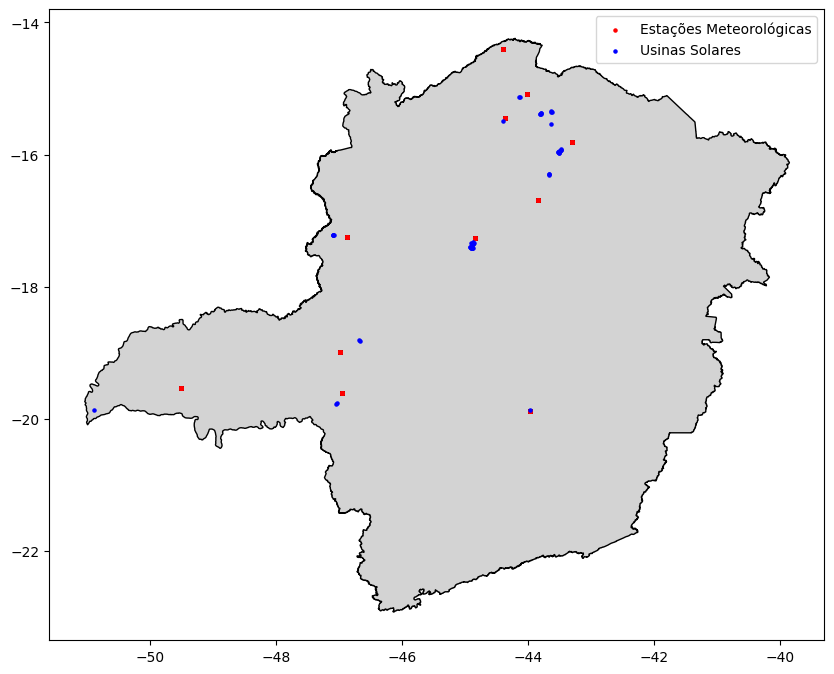

In [22]:
# Transformar em geodataframe
df_inmet['latitude'] = df_inmet['latitude'].str.replace(',', '.').astype(float)
df_inmet['longitude'] = df_inmet['longitude'].str.replace(',', '.').astype(float)

gdf_inmet = gpd.GeoDataFrame(df_inmet, geometry=gpd.points_from_xy(df_inmet.longitude, df_inmet.latitude))

# Plotar as usinas solares, as estações meteorológicas e o shapefile de Minas Gerais
fig, ax = plt.subplots(figsize=(10, 10))
gdf_mg.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_inmet.plot(ax=ax, marker='o', color='red', markersize=5, label='Estações Meteorológicas')
usinas_solares.plot(ax=ax, marker='o', color='blue', markersize=5, label='Usinas Solares')
plt.legend()
plt.show()

## Cruzamento dos Dados

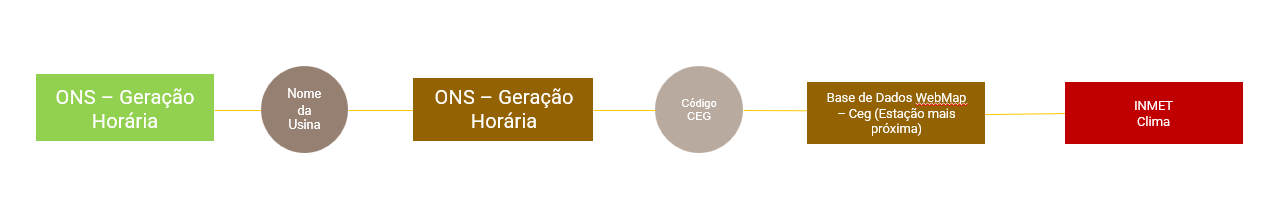

Carregamos a tabela de relação entre usinas e CEG.

In [23]:
query = " SELECT * FROM dados_ceg " 
df_ons = query_data(conn, query)

# display
display(df_ons.head())

,Conjunto,Usina,CEG
0,Conj. Araxá,UFV Araxá 1,UFV.RS.MG.040851-4.01
1,Conj. Araxá,UFV Araxá 2,UFV.RS.MG.040852-2.01
2,Conjunto Fotovoltaico Arinos 2 500 kV,UFV Arinos 11,UFV.RS.MG.047307-3.01
3,Conjunto Fotovoltaico Arinos 2 500 kV,UFV Arinos 12,UFV.RS.MG.047308-1.01
4,Conjunto Fotovoltaico Arinos 2 500 kV,UFV Arinos 13,UFV.RS.MG.047309-0.01


### Filtrar Apenas as Usinas da Tabela de Geração que Possuam CEG

Filtramos as usinas que estão na tabela de relação de geração.

In [24]:
# Obter dados de geração de usinas
query_geracao = "SELECT * FROM dados_usinas"
df_geracao = query_data(conn, query_geracao)

# Filtrar as usinas que estão na tabela de relação
df_geracao_filtrada = df_geracao[df_geracao['nom_usina'].isin(df_ons['Conjunto'])]

# Display
display(df_geracao_filtrada.head())

,din_instante,nom_subsistema,id_estado,nom_tipousina,nom_usina,ceg,val_geracao,id_ons
10943,2018-11-01 00:00:00,SUDESTE,MG,FOTOVOLTAICA,Conj. Paracatu,-,0.0,None
10946,2018-11-01 01:00:00,SUDESTE,MG,FOTOVOLTAICA,Conj. Paracatu,-,0.0,None
10948,2018-11-01 02:00:00,SUDESTE,MG,FOTOVOLTAICA,Conj. Paracatu,-,0.0,None
10949,2018-11-01 03:00:00,SUDESTE,MG,FOTOVOLTAICA,Conj. Paracatu,-,0.0,None
10952,2018-11-01 04:00:00,SUDESTE,MG,FOTOVOLTAICA,Conj. Paracatu,-,0.0,None


### Merge da Tabela Relacional com a Tabela de Geração

Mesclamos a tabela relacional com a tabela de geração para obter a geração dividida por usina.

In [25]:
# Obter todas as horas únicas no dataframe df_geracao_filtrada
horas_unicas = df_geracao_filtrada['din_instante'].unique()

df_geracao_filtrada

# # Replicar as horas no dataframe df_ons para corresponder ao número de usinas
df_ons_expandido = df_ons.loc[df_ons.index.repeat(len(horas_unicas))].reset_index(drop=True)
df_ons_expandido['din_instante'] = pd.to_datetime(list(horas_unicas) * len(df_ons), format='%Y-%m-%d %H:%M:%S')[:len(df_ons_expandido)]

# Transformar ambos em datetime
df_geracao_filtrada['din_instante'] = pd.to_datetime(df_geracao_filtrada['din_instante'])
df_ons_expandido['din_instante'] = pd.to_datetime(df_ons_expandido['din_instante'])

# Mesclar dados de geração no dataframe df_ons_expandido
df_merged = pd.merge(df_ons_expandido, df_geracao_filtrada[['nom_usina', 'din_instante', 'val_geracao']],
                     how='inner', left_on=['Conjunto', 'din_instante'], right_on=['nom_usina', 'din_instante'])

# Contar o número de usinas em cada conjunto
df_merged['usinas_no_conjunto'] = df_merged.groupby(['Conjunto', 'din_instante'])['Usina'].transform('count')

# Dividir a geração pela quantidade de usinas no conjunto para cada hora
df_merged['val_geracao_dividida'] = df_merged['val_geracao'] / df_merged['usinas_no_conjunto']

# Ajustar as colunas do dataframe para refletir o desejado
df_ons_final = df_merged[['Conjunto', 'din_instante', 'Usina', 'CEG', 'val_geracao_dividida']]
df_ons_final.rename(columns={'val_geracao_dividida': 'val_geracao', 'CEG': 'ceg'}, inplace=True)

# Display
display(df_ons_final.head())


C:\Users\afaze\AppData\Local\Temp\ipykernel_13284\2466909628.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geracao_filtrada['din_instante'] = pd.to_datetime(df_geracao_filtrada['din_instante'])
C:\Users\afaze\AppData\Local\Temp\ipykernel_13284\2466909628.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ons_final.rename(columns={'val_geracao_dividida': 'val_geracao', 'CEG': 'ceg'}, inplace=True)


,Conjunto,din_instante,Usina,ceg,val_geracao
0,Conj. Araxá,2023-01-31 00:00:00,UFV Araxá 1,UFV.RS.MG.040851-4.01,0.0
1,Conj. Araxá,2023-01-31 01:00:00,UFV Araxá 1,UFV.RS.MG.040851-4.01,0.0
2,Conj. Araxá,2023-01-31 02:00:00,UFV Araxá 1,UFV.RS.MG.040851-4.01,0.0
3,Conj. Araxá,2023-01-31 03:00:00,UFV Araxá 1,UFV.RS.MG.040851-4.01,0.0
4,Conj. Araxá,2023-01-31 04:00:00,UFV Araxá 1,UFV.RS.MG.040851-4.01,0.0


### Merge com a Tabela INMET

Finalmente, mesclamos os dados meteorológicos com os dados de geração e usinas.

In [27]:
# Converter a coluna 'din_instante' para datetime no dataframe df_ons_final
df_ons_final['din_instante'] = pd.to_datetime(df_ons_final['din_instante'], format='%Y-%m-%d %H:%M:%S')

# Converter a coluna 'data_hora_completa' para datetime no dataframe df_inmet
df_inmet['data_hora_completa'] = pd.to_datetime(df_inmet['data_hora_completa'], format='%Y-%m-%d %H:%M:%S')

# Mesclar dados meteorológicos com dados de geração e usinas
df_final = pd.merge(df_ons_final, df_inmet, how='inner', left_on=['ceg', 'din_instante'], right_on=['ceg', 'data_hora_completa'])

# Selecionar e organizar as colunas desejadas
df_final = df_final[['data_hora_completa', 'ceg', 'estacao', 'radiacao_global', 'temperatura_ar', 
                     'umidade_relativa', 'velocidade_vento', 'val_geracao']]

# Exportar para csv em processed
df_final.to_csv(os.path.join(repository_dir, 'data', 'processed', 'base_de_dados.csv'), index=False)

C:\Users\afaze\AppData\Local\Temp\ipykernel_13284\661337176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ons_final['din_instante'] = pd.to_datetime(df_ons_final['din_instante'], format='%Y-%m-%d %H:%M:%S')
